# Entity extraction (data processing)

Load packages

In [ ]:
import pandas as pd
import spacy
from tqdm import tqdm
from collections import Counter
from itertools import chain

Use GPU

In [ ]:
# Enable GPU for spaCy
spacy.require_gpu()
print("GPU Enabled:", spacy.prefer_gpu())

GPU Enabled: True


Connect google drive

In [ ]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Load data

In [ ]:
df = pd.read_parquet("/content/drive/MyDrive/Colab Notebooks/temp_data_md_bert_industry_v1.parquet", engine="pyarrow")

In [ ]:
df.head()

,index,url,date,language,title,text,clean_text_with_punct,clean_text,topic_BERT,topic_BERT_prob,Topic,Name,Predicted_Industry
0,0,https://pjmedia.com/instapundit/494418/,2022-01-01,en,Instapundit » Blog Archive » HMM: An Advan...,\n\n\nInstapundit » Blog Archive » HMM: An...,Instapundit Blog Archive HMM: An Advanced AI G...,instapundit blog archive hmm advanced give un...,247,0.455750,247,247_instapundit_heather havrilesky_tcs daily_t...,Technology
1,1,https://www.vikatan.com/amp/story/automobile%2...,2022-01-01,en,Artificial Intelligence Reshaping the Automoti...,Artificial Intelligence Reshaping the Automoti...,Artificial Intelligence Reshaping the Automoti...,reshape automotive industryx vikatan original...,20,0.599253,20,20_automotive industry_automotive_automaker_el...,Sport
2,2,https://www.equities.com/news/exchange-listed-...,2022-01-01,en,Exchange Listed Funds - QRAFT AI Enhanced U.S....,\n\nExchange Listed Funds - QRAFT AI Enhanced ...,Exchange Listed Funds - QRAFT AI Enhanced U.S....,exchange list fund qraft enhance large cap et...,-1,0.000000,-1,-1_tech_industry_technology_feature,Technology
3,3,https://www.financialexpress.com/lifestyle/boo...,2022-01-01,en,Book Review: The Age of AI and Our Human Futur...,\n\nBook Review: The Age of AI and Our Human F...,Book Review: The Age of AI and Our Human Futur...,book review age human future henry kissinger ...,-1,0.000000,-1,-1_tech_industry_technology_feature,Technology
4,4,https://www.newsbreak.com/news/2470570042311/5...,2022-01-01,en,5 Places to Start a Career in Data Science in ...,5 Places to Start a Career in Data Science in ...,5 Places to Start a Career in Data Science in -,place start career datum science,492,1.000000,492,492_india magazine_analytic india_datum scient...,Technology


Extract name entities

In [ ]:
# Load a transformer-based English NER model
nlp = spacy.load("en_core_web_trf")

# Function to extract named entities
TECH_KEYWORDS = ["AI", "model", "chatbot", "GPT", "BERT", "NLP", "Transformer",
                 "Vision", "Cloud", "LLaMA", "robot", "AV", "quantum", "blockchain",
                 "VR", "AR", "IoT", "GPU"]

def extract_entities(text):
    doc = nlp(text)
    entities = {
        "PERSON": [],
        "ORG": [],
        "TECH": [],
        "LOCATION": []
    }
    for ent in doc.ents:
        if ent.label_ == "PERSON" and ent.text.lower() not in ['ai', 'claude']:
            entities["PERSON"].append(ent.text)
        elif ent.label_ == "ORG":
            entities["ORG"].append(ent.text)
        elif ent.label_ == "PRODUCT":
            if any(kw.lower() in ent.text.lower() for kw in TECH_KEYWORDS):
                entities["TECH"].append(ent.text)
        elif ent.label_ in ["GPE", "LOC"]:  # Add location entities
            entities["LOCATION"].append(ent.text)
    return entities

In [ ]:
# Apply the extraction to cleaned text column
tqdm.pandas()
df['named_entities'] = df['clean_text_with_punct'].astype(str).progress_apply(extract_entities)

100%|██████████| 185916/185916 [5:07:21<00:00, 10.08it/s]


In [ ]:
df.head()

,index,url,date,language,title,text,clean_text_with_punct,clean_text,topic_BERT,topic_BERT_prob,Topic,Name,Predicted_Industry,named_entities
0,0,https://pjmedia.com/instapundit/494418/,2022-01-01,en,Instapundit » Blog Archive » HMM: An Advan...,\n\n\nInstapundit » Blog Archive » HMM: An...,Instapundit Blog Archive HMM: An Advanced AI G...,instapundit blog archive hmm advanced give un...,247,0.455750,247,247_instapundit_heather havrilesky_tcs daily_t...,Technology,"{'PERSON': ['ERIC ADAMS', 'Eric Adams', 'Glenn..."
1,1,https://www.vikatan.com/amp/story/automobile%2...,2022-01-01,en,Artificial Intelligence Reshaping the Automoti...,Artificial Intelligence Reshaping the Automoti...,Artificial Intelligence Reshaping the Automoti...,reshape automotive industryx vikatan original...,20,0.599253,20,20_automotive industry_automotive_automaker_el...,Sport,"{'PERSON': ['Bhargav SridharanArtificial', 'Vi..."
2,2,https://www.equities.com/news/exchange-listed-...,2022-01-01,en,Exchange Listed Funds - QRAFT AI Enhanced U.S....,\n\nExchange Listed Funds - QRAFT AI Enhanced ...,Exchange Listed Funds - QRAFT AI Enhanced U.S....,exchange list fund qraft enhance large cap et...,-1,0.000000,-1,-1_tech_industry_technology_feature,Technology,"{'PERSON': ['Jeff Kagan', 'Joan Didion'], 'ORG..."
3,3,https://www.financialexpress.com/lifestyle/boo...,2022-01-01,en,Book Review: The Age of AI and Our Human Futur...,\n\nBook Review: The Age of AI and Our Human F...,Book Review: The Age of AI and Our Human Futur...,book review age human future henry kissinger ...,-1,0.000000,-1,-1_tech_industry_technology_feature,Technology,"{'PERSON': ['Henry A Kissinger', 'Eric Schmidt..."
4,4,https://www.newsbreak.com/news/2470570042311/5...,2022-01-01,en,5 Places to Start a Career in Data Science in ...,5 Places to Start a Career in Data Science in ...,5 Places to Start a Career in Data Science in -,place start career datum science,492,1.000000,492,492_india magazine_analytic india_datum scient...,Technology,"{'PERSON': [], 'ORG': [], 'TECH': [], 'LOCATIO..."


Save data

In [ ]:
df.to_parquet("/content/drive/MyDrive/Colab Notebooks/temp_data_md_entities.parquet", engine="pyarrow", index=False)

Look into the result (initial). Detailed analysis will be in other scripts.

In [ ]:
def normalize_entity_list(entity_list):
    if not isinstance(entity_list, list):
        return []
    return [ent.strip().lower().title() for ent in entity_list]

In [ ]:
# Normalize named entities
df['normalized_entities'] = df['named_entities'].apply(lambda ents: {
    k: normalize_entity_list(v) for k, v in ents.items()
})

In [ ]:
orgs = Counter(chain.from_iterable(df['normalized_entities'].dropna().apply(lambda x: x['ORG'])))
people = Counter(chain.from_iterable(df['normalized_entities'].dropna().apply(lambda x: x['PERSON'])))
techs = Counter(chain.from_iterable(df['normalized_entities'].dropna().apply(lambda x: x['TECH'])))
locations = Counter(chain.from_iterable(df['normalized_entities'].dropna().apply(lambda x: x['LOCATION'])))


In [ ]:
# Show top 20 results
print("\nTop Organizations:\n", orgs.most_common(20))
print("\nTop People:\n", people.most_common(20))
print("\nTop Technologies:\n", techs.most_common(20))
print("\nTop Locations:\n", locations.most_common(20))


Top Organizations:
 [('Openai', 164609), ('Google', 163236), ('Microsoft', 132160), ('Apple', 80942), ('Nvidia', 66114), ('Chatgpt', 57172), ('Amazon', 52961), ('Lg', 46763), ('Fcc', 40113), ('Meta', 38344), ('Facebook', 36808), ('Samsung', 35254), ('Youtube', 33292), ('Linkedin', 28920), ('Twitter', 22338), ('Digi Communications N.V.', 20767), ('Nasdaq', 19840), ('Ap', 18394), ('Intel', 17799), ('Instagram', 17206)]

Top People:
 [('Trump', 29713), ('Biden', 23695), ('Altman', 21742), ('Sam Altman', 21191), ('Musk', 20552), ('Elon Musk', 20006), ('Donald Trump', 8649), ('Taylor Swift', 8504), ('Modi', 6908), ('Joe Biden', 6807), ('Putin', 4420), ('Bobby Allyn', 3960), ('Satya Nadella', 3861), ('Mark Zuckerberg', 3538), ('Kim Kardashian', 3518), ('Sundar Pichai', 3362), ('Bard', 3353), ('Charles', 3281), ('Harris', 3280), ('Narendra Modi', 3142)]

Top Technologies:
 [('Chatgpt', 121133), ('Bard', 13270), ('Generative Ai', 4000), ('Openai', 3083), ('Chatgpt Plus', 2889), ('Ultragear', 

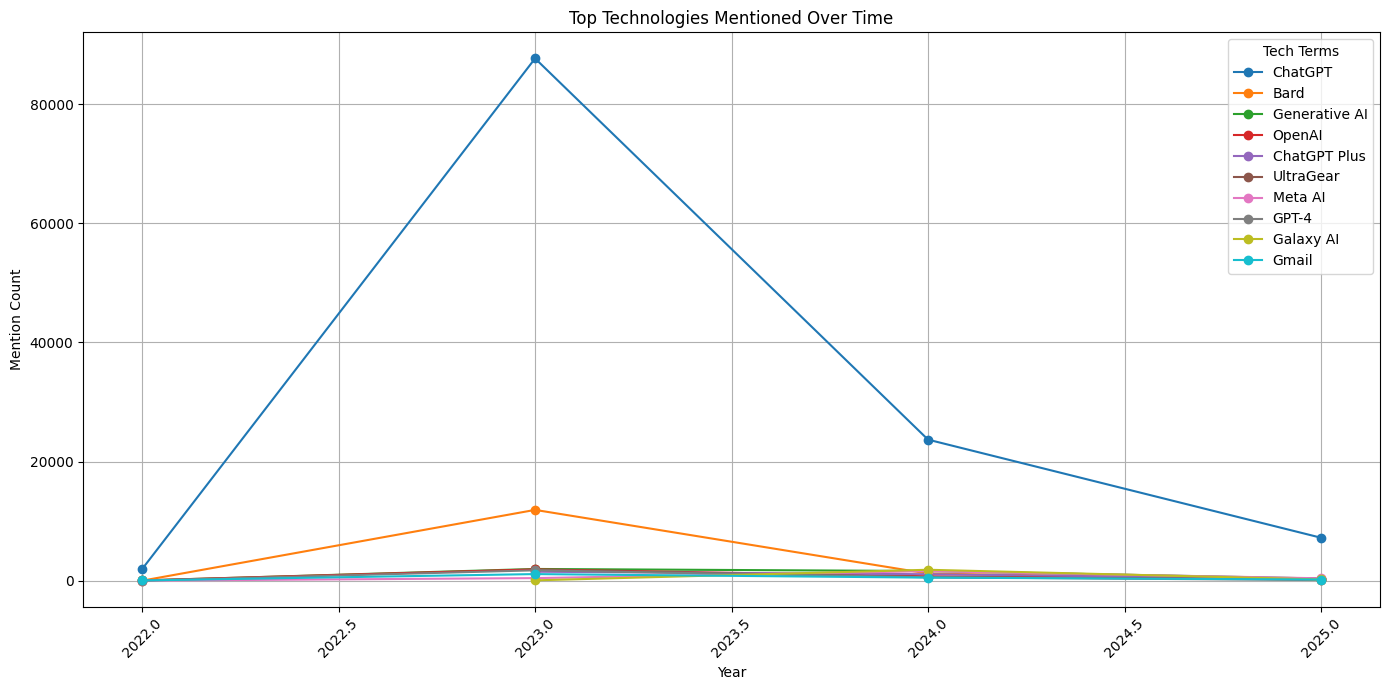

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from itertools import chain

# Ensure the date column is in datetime format and extract year
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df['year'] = df['date'].dt.year

# Keep rows that have named_entities and valid year
df_valid = df[df['named_entities'].notna()].copy()
df_valid = df_valid[df_valid['year'].notna()]
df_valid['year'] = df_valid['year'].astype(int)

# Flatten the TECH entities with their corresponding year
tech_mentions = []
for _, row in df_valid.iterrows():
    for tech in row['named_entities'].get('TECH', []):
        tech_mentions.append((row['year'], tech.strip()))

# Create a DataFrame
df_tech = pd.DataFrame(tech_mentions, columns=['year', 'tech'])

# Count frequency of each tech by year
tech_counts = df_tech.groupby(['year', 'tech']).size().reset_index(name='count')

# Get the top 10 most mentioned tech terms overall
top_tech_terms = tech_counts.groupby('tech')['count'].sum().nlargest(10).index.tolist()
df_top = tech_counts[tech_counts['tech'].isin(top_tech_terms)]

# Plot the top tech terms over time
plt.figure(figsize=(14, 7))
for tech in top_tech_terms:
    yearly_data = df_top[df_top['tech'] == tech]
    plt.plot(yearly_data['year'], yearly_data['count'], marker='o', label=tech)

plt.title("Top Technologies Mentioned Over Time")
plt.xlabel("Year")
plt.ylabel("Mention Count")
plt.legend(title="Tech Terms")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


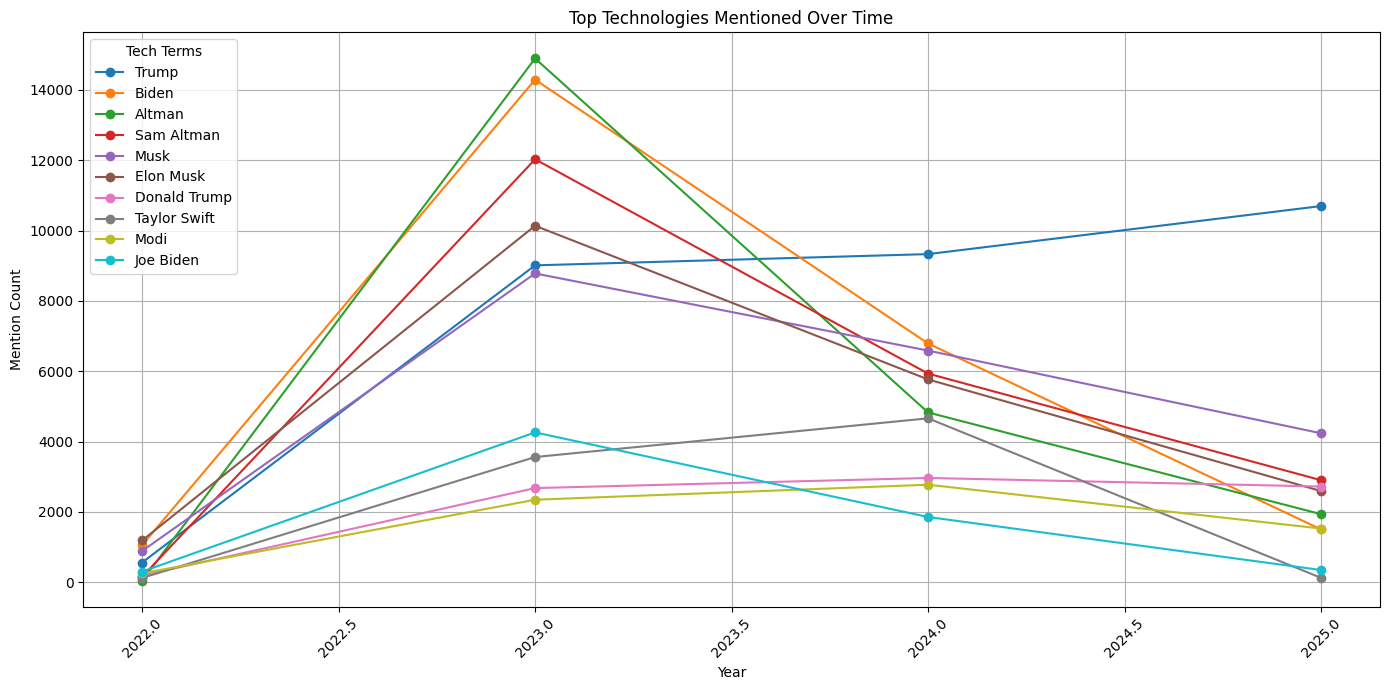

In [ ]:
# Flatten the TECH entities with their corresponding year
tech_mentions = []
for _, row in df_valid.iterrows():
    for tech in row['named_entities'].get('PERSON', []):
        tech_mentions.append((row['year'], tech.strip()))

# Create a DataFrame
df_tech = pd.DataFrame(tech_mentions, columns=['year', 'tech'])

# Count frequency of each tech by year
tech_counts = df_tech.groupby(['year', 'tech']).size().reset_index(name='count')

# Get the top 10 most mentioned tech terms overall
top_tech_terms = tech_counts.groupby('tech')['count'].sum().nlargest(10).index.tolist()
df_top = tech_counts[tech_counts['tech'].isin(top_tech_terms)]

# Plot the top tech terms over time
plt.figure(figsize=(14, 7))
for tech in top_tech_terms:
    yearly_data = df_top[df_top['tech'] == tech]
    plt.plot(yearly_data['year'], yearly_data['count'], marker='o', label=tech)

plt.title("Top Technologies Mentioned Over Time")
plt.xlabel("Year")
plt.ylabel("Mention Count")
plt.legend(title="Tech Terms")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
def fix_common_location_alias(loc):
    loc = loc.strip().lower()
    if loc in ['us', 'u.s.', 'united states', 'usa']:
        return 'United States'
    elif loc in ['uk', 'united kingdom']:
        return 'United Kingdom'
    else:
        return loc.title()

# Replace in location lists
df['normalized_entities'] = df['normalized_entities'].apply(lambda ents: {
    **ents,
    'LOCATION': [fix_common_location_alias(loc) for loc in ents.get('LOCATION', [])]
})


In [ ]:
# Aggregate entity mentions
orgs = Counter(chain.from_iterable(df['named_entities'].dropna().apply(lambda x: x['ORG'])))
people = Counter(chain.from_iterable(df['named_entities'].dropna().apply(lambda x: x['PERSON'])))
techs = Counter(chain.from_iterable(df['named_entities'].dropna().apply(lambda x: x['TECH'])))
locations = Counter(chain.from_iterable(df['named_entities'].dropna().apply(lambda x: x['LOCATION'])))

In [ ]:
# Show top 20 results
print("\nTop Organizations:\n", orgs.most_common(20))
print("\nTop People:\n", people.most_common(20))
print("\nTop Technologies:\n", techs.most_common(20))
print("\nTop Locations:\n", locations.most_common(20))


Top Organizations:
 [('OpenAI', 163473), ('Google', 162440), ('Microsoft', 131725), ('Apple', 80599), ('ChatGPT', 56660), ('Amazon', 52035), ('LG', 46759), ('Nvidia', 46109), ('FCC', 40113), ('Meta', 37005), ('Facebook', 35911), ('Samsung', 34771), ('LinkedIn', 27798), ('YouTube', 26667), ('Twitter', 22251), ('NVIDIA', 19680), ('AP', 18393), ('Intel', 17741), ('Instagram', 17028), ('AMD', 17015)]

Top People:
 [('Trump', 29608), ('Biden', 23645), ('Altman', 21711), ('Sam Altman', 21022), ('Musk', 20500), ('Elon Musk', 19692), ('Donald Trump', 8560), ('Taylor Swift', 8476), ('Modi', 6906), ('Joe Biden', 6773), ('Putin', 4416), ('Bobby Allyn', 3908), ('Satya Nadella', 3805), ('Kim Kardashian', 3516), ('Mark Zuckerberg', 3506), ('Sundar Pichai', 3348), ('Bard', 3284), ('Charles', 3279), ('Harris', 3273), ('Narendra Modi', 3137)]

Top Technologies:
 [('ChatGPT', 120533), ('Bard', 13224), ('Generative AI', 3992), ('OpenAI', 3024), ('ChatGPT Plus', 2876), ('UltraGear', 2660), ('Meta AI', 24